In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import BoundaryNorm
from scipy.stats import linregress, pearsonr
import pandas as pd
from glob import glob
from scipy.interpolate import griddata

# Look at the land cover

In [2]:
#
pft_list =  {0: 'not_vegetated', 
             1: 'needleleaf_evergreen_temperate_tree', 
             2: 'needleleaf_evergreen_boreal_tree', 
             3: 'needleleaf_deciduous_boreal_tree', 
             4: 'broadleaf_evergreen_tropical_tree', 
             5: 'broadleaf_evergreen_temperate_tree', 
             6: 'broadleaf_deciduous_tropical_tree', 
             7: 'broadleaf_deciduous_temperate_tree', 
             8: 'broadleaf_deciduous_boreal_tree', 
             9: 'broadleaf_evergreen_shrub', 
            10: 'broadleaf_deciduous_temperate_shrub', 
            11: 'broadleaf_deciduous_boreal_shrub', 
            12: 'c3_arctic_grass', 
            13: 'c3_non-arctic_grass', 
            14: 'c4_grass', 
            15: 'c3_crop', 
            16: 'c3_irrigated'}

# Check the input land cover files
path_luc = os.path.join(os.environ['PROJDIR'], 'E3SM', 'inputdata', 'lnd', 'clm2', 
                        'surfdata_map', 
                        'landuse.timeseries_conus_erw_off_hist_simyr1850_c240712.nc')
hr = xr.open_dataset(path_luc)

# 2015 values
fig, axes = plt.subplots(4, 4, figsize = (20, 12), sharex = True, sharey = True,
                         subplot_kw = {'projection': ccrs.PlateCarree()})
for i in range(16):
    ax = axes.flat[i]
    ax.coastlines()
    cf = ax.contourf(hr['LONGXY'][0, :], hr['LATIXY'][:,0], hr['PCT_NAT_PFT'][-1, i, :, :],
                     levels = np.linspace(0, 100, 21), cmap = 'Spectral')
    ax.set_title(pft_list[i])
cax = fig.add_axes([0.05, 0.1, 0.01, 0.8])
plt.colorbar(cf, cax = cax, orientation = 'vertical')

FileNotFoundError: [Errno 2] No such file or directory: b'/gpfs/wolf2/cades/cli185/scratch/ywo/E3SM/inputdata/lnd/clm2/surfdata_map/landuse.timeseries_conus_erw_off_hist_simyr1850_c240712.nc'

In [ ]:
# Check the static surfdata
path_luc = os.path.join(os.environ['PROJDIR'], 'E3SM', 'inputdata', 'lnd', 'clm2', 
                        'surfdata_map', 
                        'surfdata_conus_erw_off_simyr1850_c211019.nc')
hr = xr.open_dataset(path_luc)

# 2015 values
fig, axes = plt.subplots(4, 4, figsize = (20, 12), sharex = True, sharey = True,
                         subplot_kw = {'projection': ccrs.PlateCarree()})
for i in range(16):
    ax = axes.flat[i]
    ax.coastlines()
    cf = ax.contourf(hr['LONGXY'][0, :], hr['LATIXY'][:,0], hr['PCT_NAT_PFT'][i, :, :],
                     levels = np.linspace(0, 100, 21), cmap = 'Spectral')
    ax.set_title(pft_list[i])
cax = fig.add_axes([0.05, 0.1, 0.01, 0.8])
plt.colorbar(cf, cax = cax, orientation = 'vertical')

# Check the simulated values in general

In [2]:
flist = [os.path.join(os.environ['E3SM_ROOT'], 'output', 
                      'ERW_ctrl_hcru_hcru_ICB20TRCNPRDCTCBC', 'run', 
                      f'ERW_ctrl_hcru_hcru_ICB20TRCNPRDCTCBC.elm.h1.{year}-01-01-00000.nc') \
         for year in range(1990, 2010)]
hr = xr.open_mfdataset(flist)
#filename = os.path.join(os.environ['PROJDIR'], 'E3SM', 'output', 
#                        'ERW_ctrl_hcru_hcru_ICB1850CNRDCTCBC_ad_spinup', 'run', 
#                        'ERW_ctrl_hcru_hcru_ICB1850CNRDCTCBC_ad_spinup.elm.h0.0201-01-01-00000.nc')
#hr = xr.open_dataset(filename)
#filename = os.path.join(os.environ['PROJDIR'],'E3SM','output', 
#                                   'ERW_off_hcru_hcru_ICB20TRCNPRDCTCBC', 'run', 
#                            'ERW_off_hcru_hcru_ICB20TRCNPRDCTCBC.elm.h1.1851-01-01-00000.nc')
#hr = xr.open_dataset(filename)

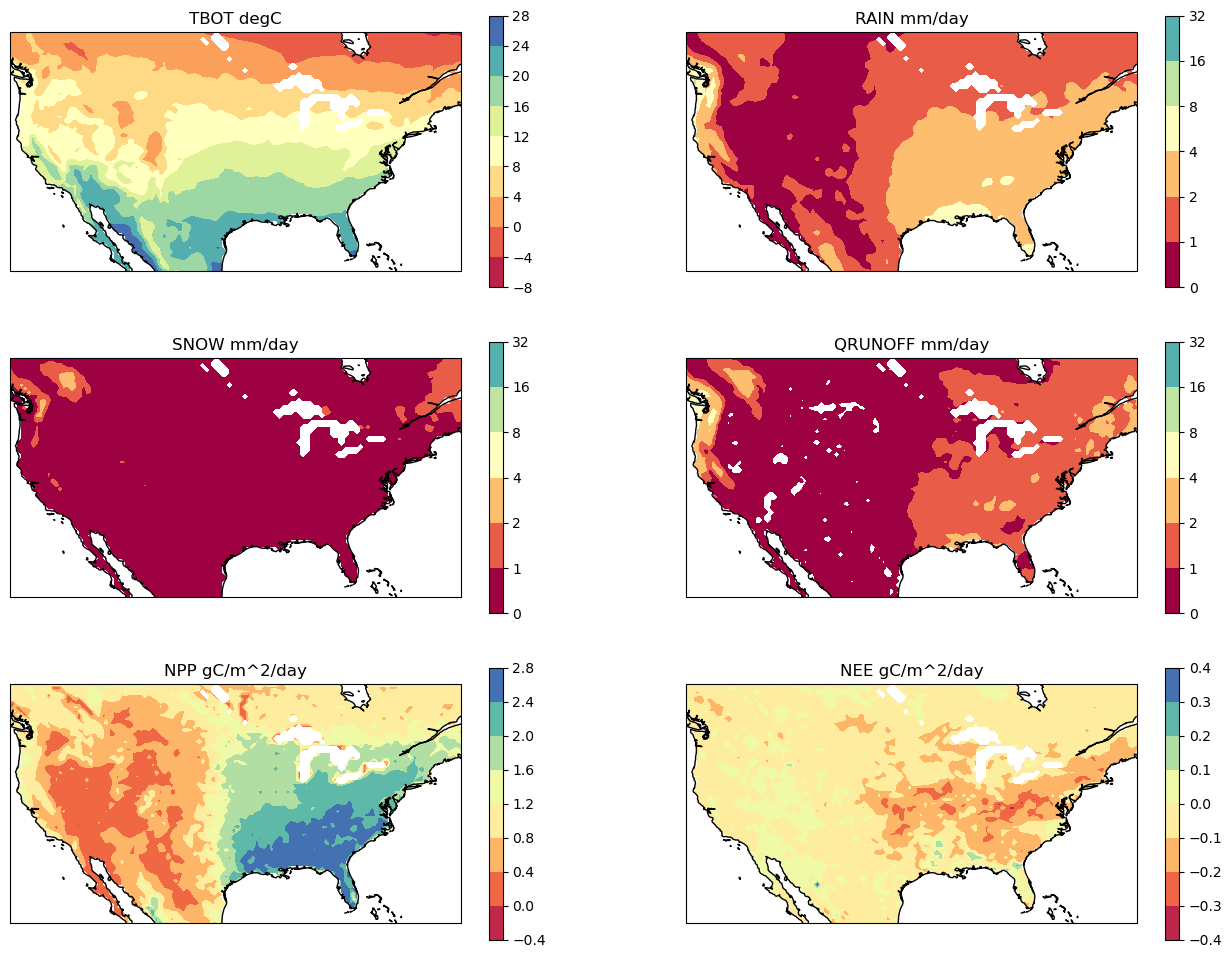

In [ ]:
fig, axes = plt.subplots(3, 2, figsize = (16, 12), subplot_kw = {'projection': ccrs.PlateCarree()})

for i, var in enumerate(['TBOT', 'RAIN', 'SNOW', 'QRUNOFF', 'NPP', 'NEE']):
    ax = axes.flat[i]
    ax.coastlines()
    if var != 'TBOT':
        data = hr[var].mean(axis = 0) * 86400
    else:
        data = hr[var].mean(axis = 0) - 273.15
    if var in ['RAIN', 'SNOW', 'QRUNOFF']:
        norm = BoundaryNorm([0, 1, 2, 4, 8, 16, 32], ncolors=256, extend='max')
        cf = ax.contourf(hr['lon'], hr['lat'], data, cmap = 'Spectral',
                         norm = norm, levels = [0, 1, 2, 4, 8, 16, 32])
        plt.colorbar(cf, ax = ax)
    else:
        cf = ax.contourf(hr['lon'], hr['lat'], data, cmap = 'Spectral')
        plt.colorbar(cf, ax = ax)
    ax.set_title(var + ' ' + hr[var].attrs['units'].replace('s','day').replace('K','degC'))

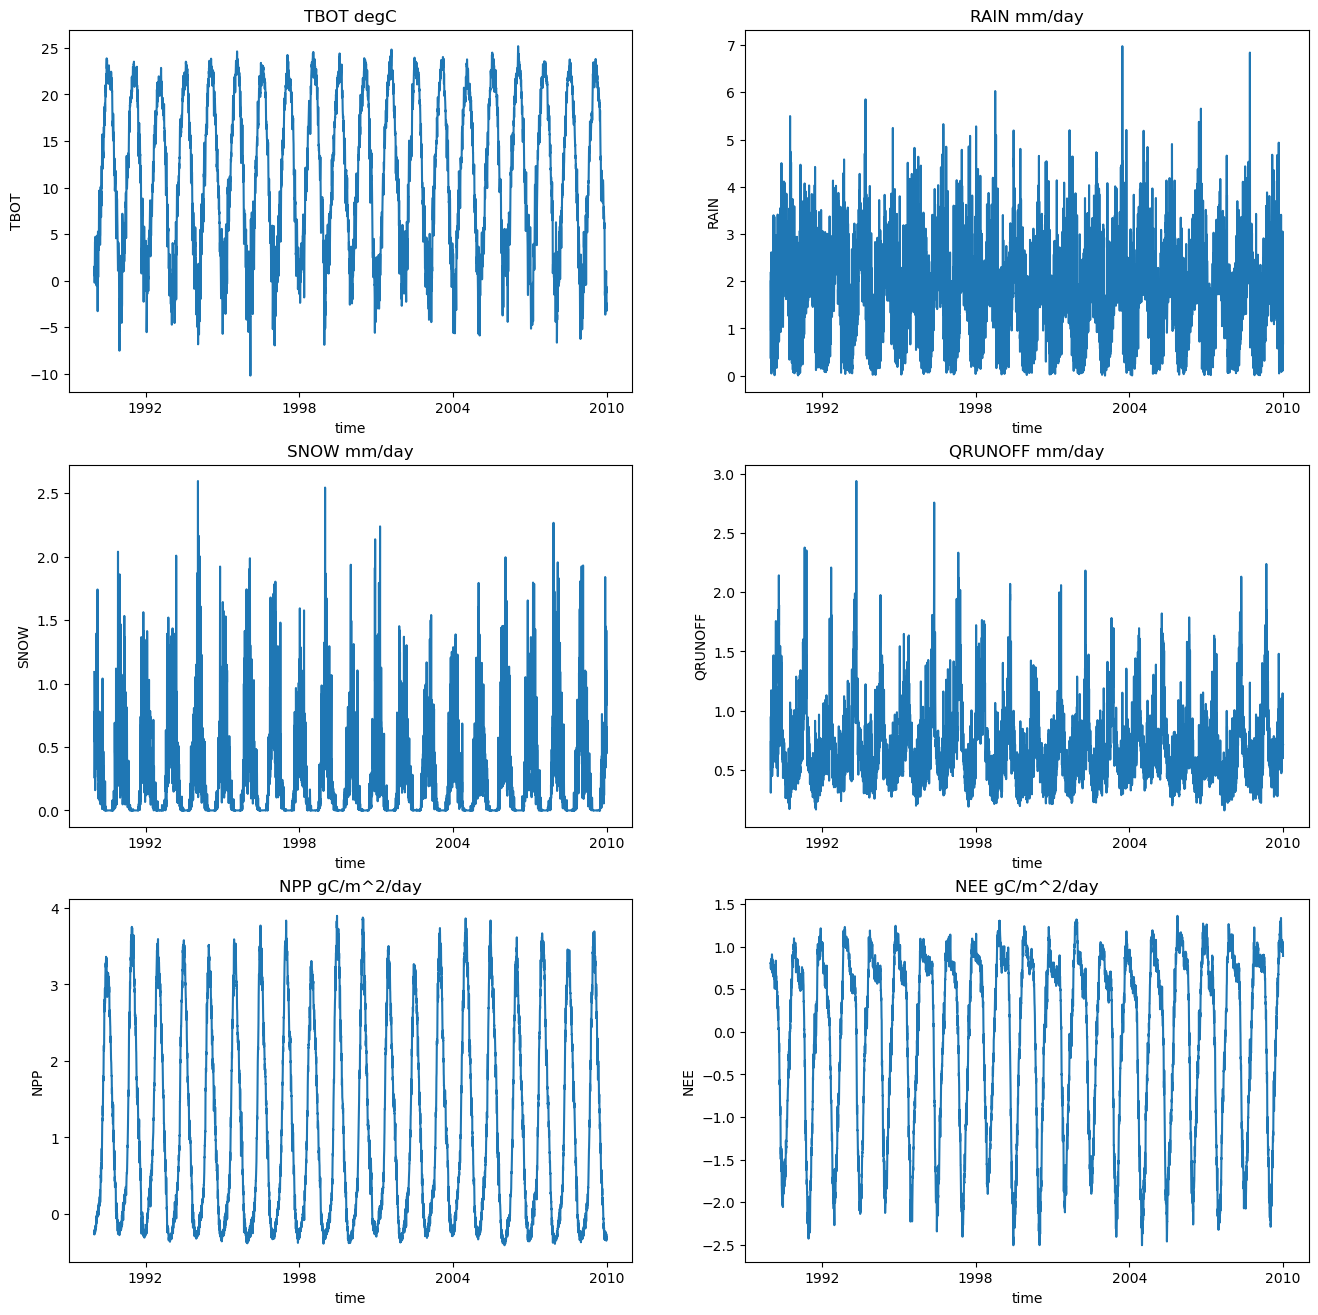

In [ ]:
# Plot regional trajectories
fig, axes = plt.subplots(3, 2, figsize = (16, 16))
for i, var in enumerate(['TBOT', 'RAIN', 'SNOW', 'QRUNOFF', 'NPP', 'NEE']):
    ax = axes.flat[i]
    if var != 'TBOT':
        data = hr[var].mean(axis=2).mean(axis=1) * 86400
    else:
        data = hr[var].mean(axis=2).mean(axis=1) - 273.15
    data.plot(ax = ax)
    ax.set_title(var + ' ' + hr[var].attrs['units'].replace('s','day').replace('K','degC'))

# Compare against observed runoff

/ccsopen/home/ywo/.conda/envs/myCondaEnv/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'shrink'
  result = super().contourf(*args, **kwargs)


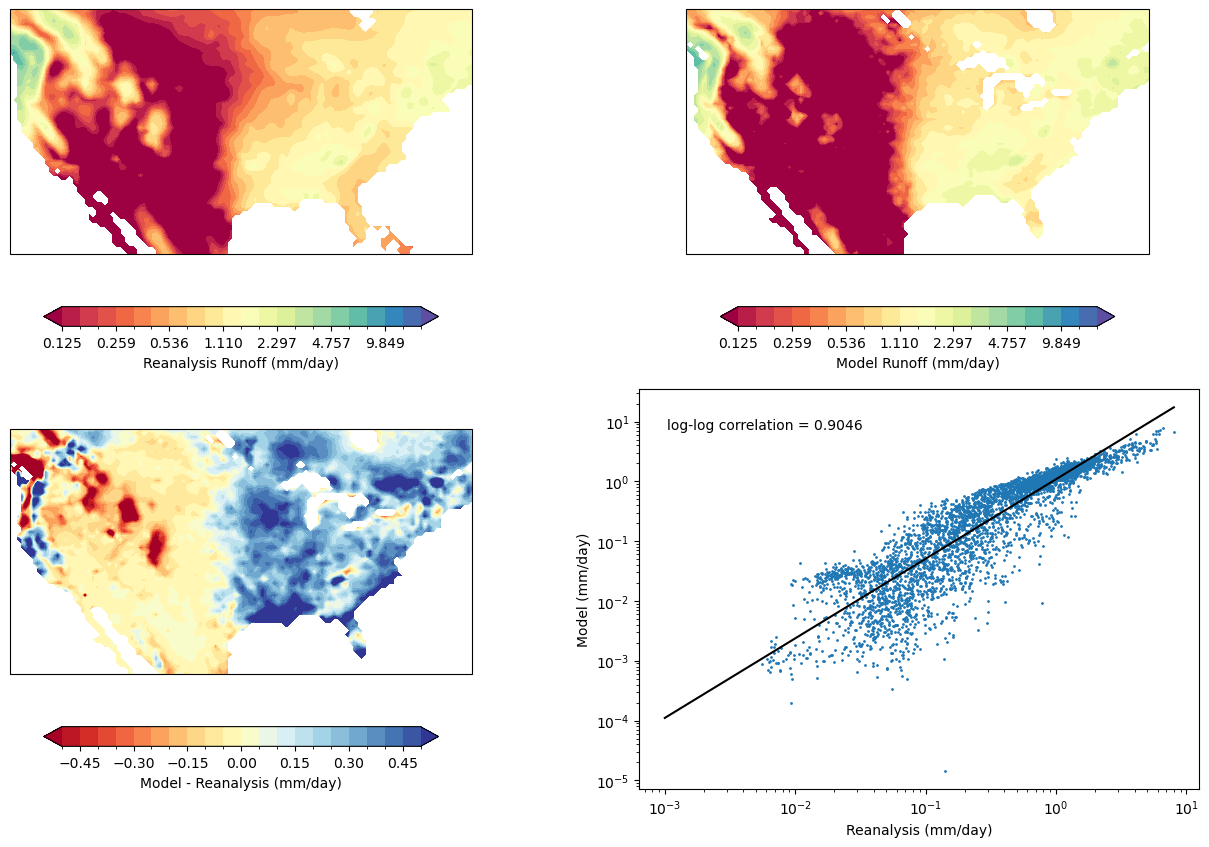

In [ ]:
grun = xr.open_dataset(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'GRUN',
                                    'G-RUN_ENSEMBLE_MMM_CONUS.nc'))

fig, axes = plt.subplots(2, 2, figsize = (16, 10), subplot_kw = {'projection': ccrs.PlateCarree()})

levels = 2**np.linspace(-3, 4, 21)
norm = BoundaryNorm(levels, ncolors=256, extend='both')

ax = axes.flat[0]
data = grun['Runoff'].mean(axis = 0)
cf = ax.contourf(grun['lon'], grun['lat'], data, cmap = 'Spectral',
                 norm = norm, levels = levels, extend = 'both')
plt.colorbar(cf, ax = ax, label = 'Reanalysis Runoff (mm/day)', 
             orientation = 'horizontal', shrink = 0.7)

ax = axes.flat[1]
data2 = hr['QRUNOFF'].mean(axis = 0) * 86400
cf = ax.contourf(grun['lon'], grun['lat'], data2,
                 cmap = 'Spectral', norm = norm, levels = levels, extend = 'both')
plt.colorbar(cf, ax = ax, label = 'Model Runoff (mm/day)', 
             orientation = 'horizontal', shrink = 0.7)

levels = np.linspace(-0.5, 0.5, 21)
norm = BoundaryNorm(levels, ncolors=256, extend='both')

ax = axes.flat[2]
cf = ax.contourf(grun['lon'], grun['lat'], data2 - data.values,
                 cmap = 'RdYlBu', norm = norm, levels = levels, extend = 'both', 
                 shrink = 0.7)
plt.colorbar(cf, ax = ax, label = 'Model - Reanalysis (mm/day)', 
             orientation = 'horizontal', shrink = 0.7)

axes.flat[-1].axis('off')

cax = fig.add_axes([0.55, 0.1, 0.35, 0.4])

x = data.values.reshape(-1)
y = data2.values.reshape(-1)
filt = (x > 0) & (y > 0) # ELM runoff has tiny negative values!
x = x[filt]
y = y[filt]

cax.plot(x, y, 'o', markersize = 1)
cax.set_xlabel('Reanalysis (mm/day)')
cax.set_ylabel('Model (mm/day)')
cax.set_xscale('log')
cax.set_yscale('log')

res = linregress(np.log(x), np.log(y))
cax.plot([1e-3, 8], [np.exp(np.log(1e-3)*res.slope+res.intercept), 
                  np.exp(np.log(8)*res.slope+res.intercept)], '-k')
rho, pval = pearsonr(np.log(x), np.log(y))
cax.text(0.05, 0.9, f'log-log correlation = {rho:.04f}', transform = cax.transAxes)

grun.close()

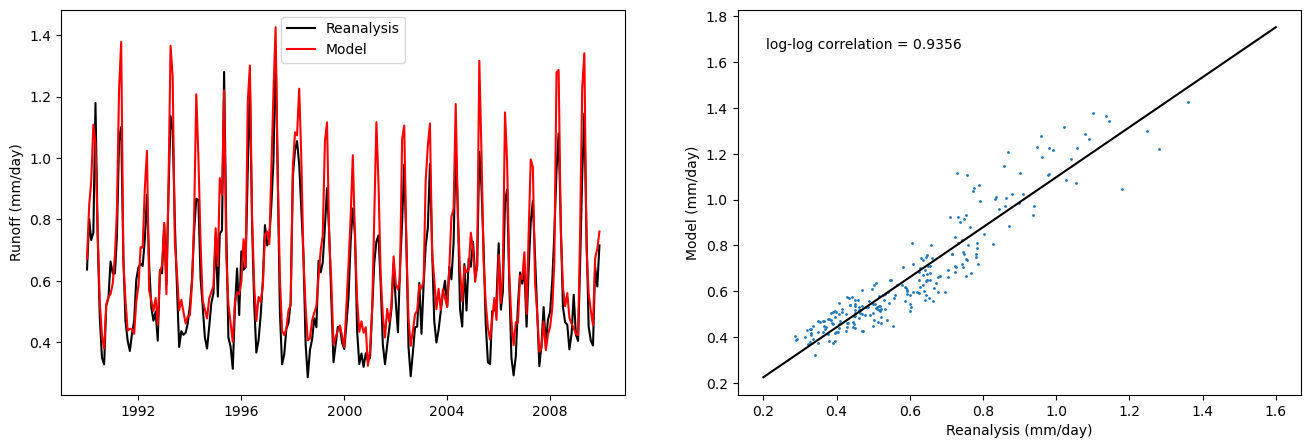

In [ ]:
grun = xr.open_dataset(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'GRUN',
                                    'G-RUN_ENSEMBLE_MMM_CONUS.nc'))

fig, axes = plt.subplots(1, 2, figsize = (16, 5))

data = grun['Runoff'].mean(axis = 2).mean(axis = 1)
data2 = hr['QRUNOFF'].mean(axis = 2).mean(axis = 1).resample(time='1M').mean() * 86400

ax = axes.flat[0]
ax.plot(data['time'].to_index(), data.values, '-k', label = 'Reanalysis')
ax.plot(data['time'].to_index(), data2.values, '-r', label = 'Model')
ax.set_ylabel('Runoff (mm/day)')
ax.legend()

ax = axes.flat[1]
ax.plot(data.values, data2.values, 'o', markersize = 1)
ax.set_xlabel('Reanalysis (mm/day)')
ax.set_ylabel('Model (mm/day)')

res = linregress(data.values, data2.values)
ax.plot([0.2, 1.6], [0.2*res.slope+res.intercept, 1.6*res.slope+res.intercept], '-k')
rho, pval = pearsonr(data.values, data2.values)
ax.text(0.05, 0.9, f'log-log correlation = {rho:.04f}', transform = ax.transAxes)

grun.close()

In [ ]:
# Compare JRA forcing's precipitation and GSWP's precipitation seasonality

TBC

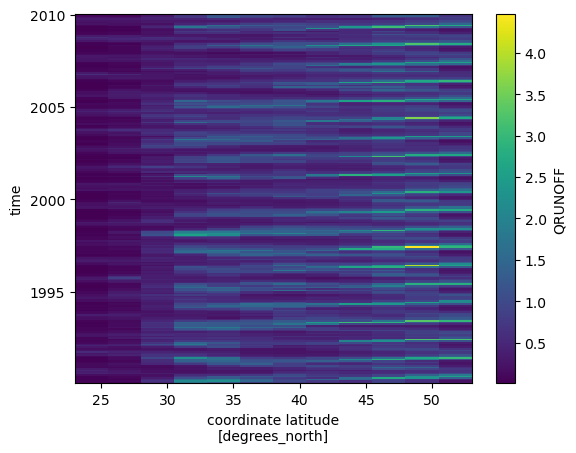

In [12]:
# Compare the latitude-specific runoff seasonality

# modeled
lat_qrunoff = (hr['QRUNOFF'].resample(time='1M').mean() * 86400)
lat_qrunoff = lat_qrunoff.mean(axis = 2).coarsen(lat = 5, boundary = 'trim').mean()
lat_qrunoff = lat_qrunoff.load()

# grun
grun = xr.open_dataset(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'GRUN',
                                    'G-RUN_ENSEMBLE_MMM_CONUS.nc'))
data = grun['Runoff'].mean(axis = 2).coarsen(lat=5, boundary="trim").mean()
data = data.copy().load()
grun.close()

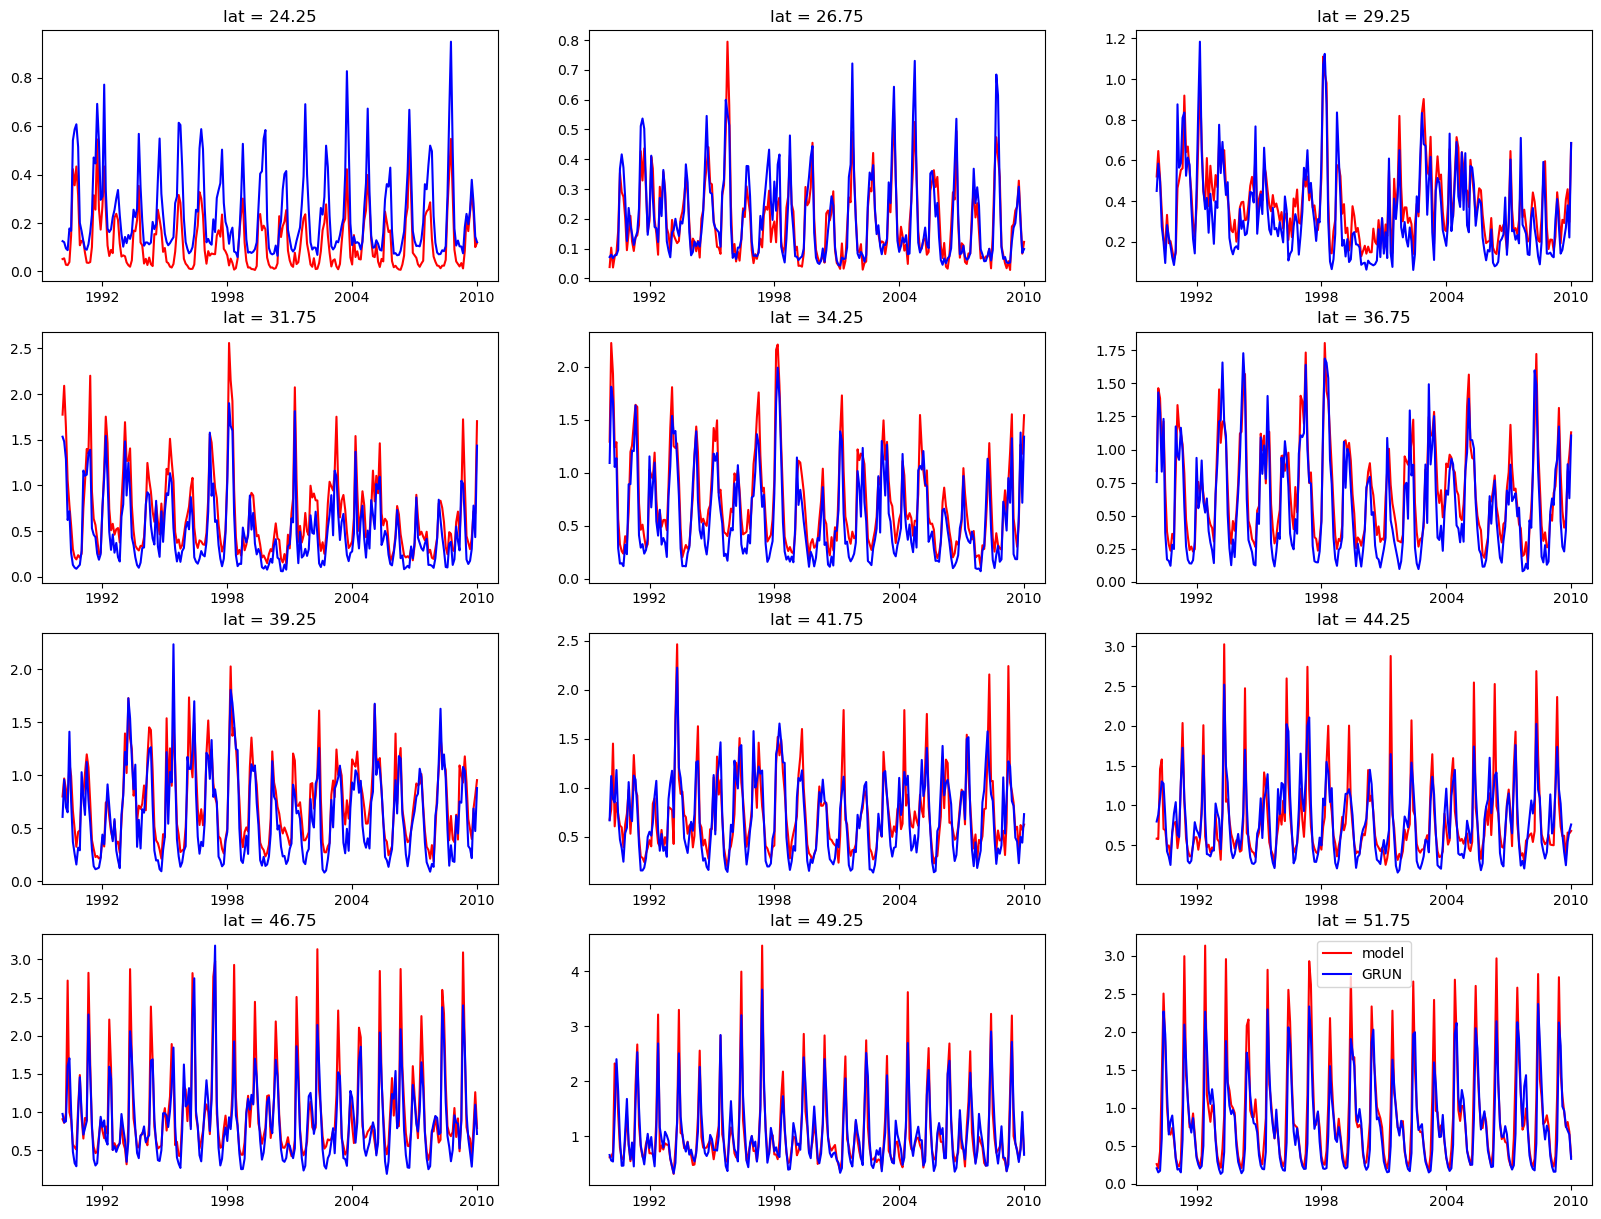

In [24]:
# Time series
tvec = lat_qrunoff['time'].to_index()
fig, axes = plt.subplots(4, 3, figsize = (20, 15))
for i in range(12):
    ax = axes.flat[i]
    ax.plot(tvec, lat_qrunoff[:, i].values, '-r', label = 'model')
    ax.plot(tvec, data[:, i].values, '-b', label = 'GRUN')
    ax.set_title('lat = ' + str(data['lat'].values[i]))
ax.legend()

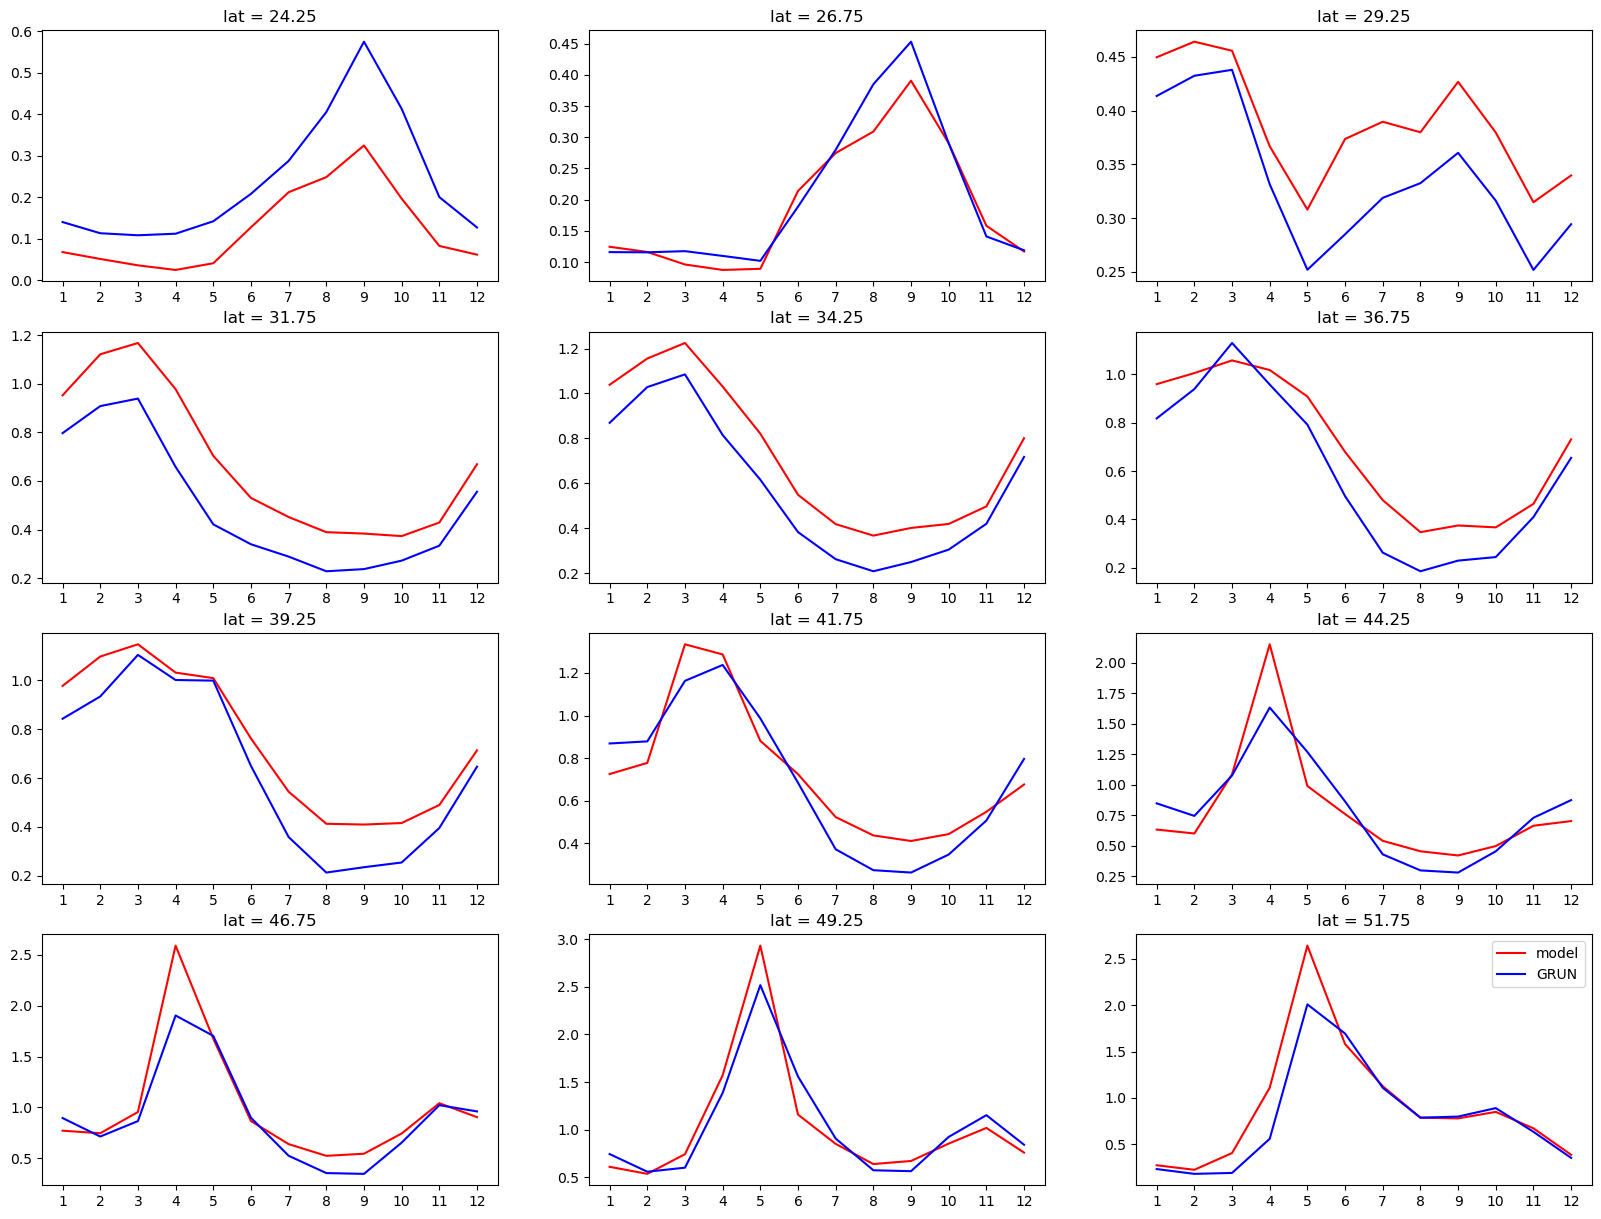

In [27]:
# Seasonality (12 month)
tvec = lat_qrunoff['time'].to_index()
fig, axes = plt.subplots(4, 3, figsize = (20, 15))
for i in range(12):
    ax = axes.flat[i]
    ax.plot(range(1,13), lat_qrunoff[:, i].values.reshape(-1,12).mean(axis = 0), 
            '-r', label = 'model')
    ax.plot(range(1,13), data[:, i].values.reshape(-1,12).mean(axis = 0), 
            '-b', label = 'GRUN')
    ax.set_title('lat = ' + str(data['lat'].values[i]))
    ax.set_xticks(range(1,13))
ax.legend()

In [29]:
# HBR
# -76.28,41.05,-70.26,44.93
box_qrunoff = hr['QRUNOFF'].sel(lon = slice(-76.28+360, -70.26+360), lat = slice(41.05,44.93) \
                                ).mean(axis = 2).mean(axis = 1).resample(time='1M').mean() * 86400
box_qrunoff.load()

grun = xr.open_dataset(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'GRUN',
                                    'G-RUN_ENSEMBLE_MMM_CONUS.nc'))
data = grun['Runoff'].sel(lon = slice(-76.28, -70.26), lat = slice(41.05,44.93) \
                         ).mean(axis = 2).mean(axis = 1)
data = data.load().copy()
grun.close()

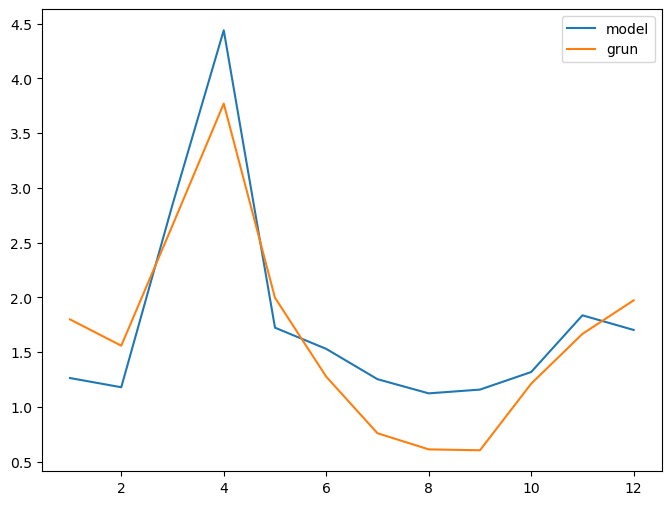

In [42]:
fig, ax = plt.subplots(figsize = (8, 6))
#ax.plot(box_qrunoff['time'].to_index(), box_qrunoff)
#ax.plot(box_qrunoff['time'].to_index(), data)
ax.plot(range(1,13), box_qrunoff.values.reshape(-1, 12).mean(axis = 0), label = 'model')
ax.plot(range(1,13), data.values.reshape(-1, 12).mean(axis = 0), label = 'grun')
ax.legend()

# Compare against observed LAI

In [ ]:
modis = xr.open_dataset(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'ILAMB',
                                     'MODIS_lai_0.5x0.5.nc'))

time_slice = slice('2000-01-01', '2005-12-31')  # Replace with your desired time range
bounding_box = {'lon': slice(-125.25, -66.5), 'lat': slice(23.25, 54.7)}
lai_obs = modis['lai'].sel(lat = bounding_box['lat'], lon = bounding_box['lon']).load()

lai_sim = hr['TLAI'].sel(time=time_slice).resample(time='1M').mean().load()

/ccsopen/home/ywo/.conda/envs/myCondaEnv/lib/python3.11/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'lai' has multiple fill values {1e+36, -999.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


/ccsopen/home/ywo/.conda/envs/myCondaEnv/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'shrink'
  result = super().contourf(*args, **kwargs)


Text(0.05, 0.9, 'correlation = 0.6620')

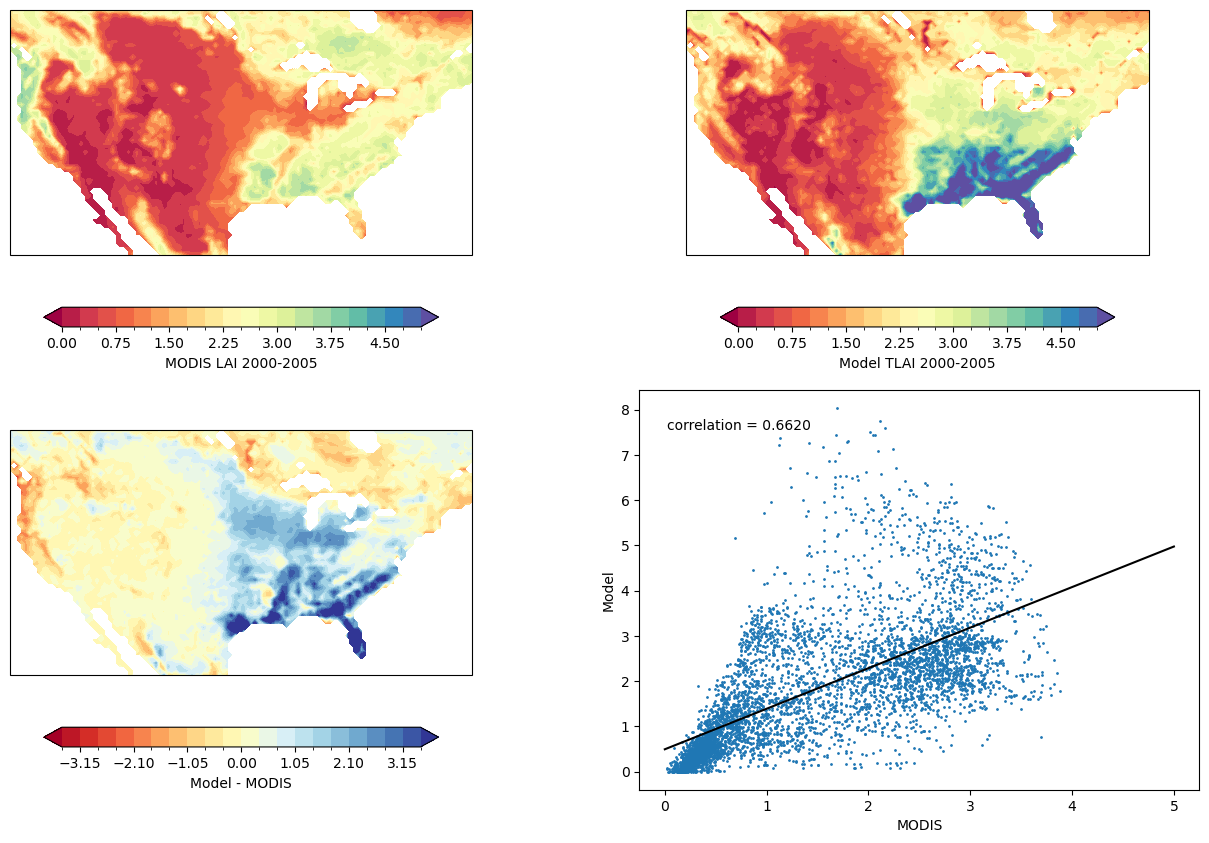

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (16, 10), subplot_kw = {'projection': ccrs.PlateCarree()})

levels = np.linspace(0, 5, 21)
norm = BoundaryNorm(levels, ncolors=256, extend='both')

ax = axes.flat[0]
data = lai_obs.mean(axis = 0)
cf = ax.contourf(data['lon'], data['lat'], data, cmap = 'Spectral',
                 norm = norm, levels = levels, extend = 'both')
plt.colorbar(cf, ax = ax, label = 'MODIS LAI 2000-2005', 
             orientation = 'horizontal', shrink = 0.7)

ax = axes.flat[1]
data2 = lai_sim.mean(axis = 0)
cf = ax.contourf(data2['lon'], data2['lat'], data2,
                 cmap = 'Spectral', norm = norm, levels = levels, extend = 'both')
plt.colorbar(cf, ax = ax, label = 'Model TLAI 2000-2005', 
             orientation = 'horizontal', shrink = 0.7)

levels = np.linspace(-3.5, 3.5, 21)
norm = BoundaryNorm(levels, ncolors=256, extend='both')

ax = axes.flat[2]
cf = ax.contourf(data2['lon'], data2['lat'], data2 - data.values,
                 cmap = 'RdYlBu', norm = norm, levels = levels, extend = 'both', 
                 shrink = 0.7)
plt.colorbar(cf, ax = ax, label = 'Model - MODIS', 
             orientation = 'horizontal', shrink = 0.7)

axes.flat[-1].axis('off')

cax = fig.add_axes([0.55, 0.1, 0.35, 0.4])

x = data.values.reshape(-1)
y = data2.values.reshape(-1)
filt = (x > 0) & (y > 0) # ELM runoff has tiny negative values!
x = x[filt]
y = y[filt]

cax.plot(x, y, 'o', markersize = 1)
cax.set_xlabel('MODIS')
cax.set_ylabel('Model')

res = linregress(x, y)
cax.plot([0, 5], [0*res.slope+res.intercept, 5*res.slope+res.intercept], '-k')
rho, pval = pearsonr(x, y)
cax.text(0.05, 0.9, f'correlation = {rho:.04f}', transform = cax.transAxes)

Text(0.05, 0.9, 'correlation = 0.9069')

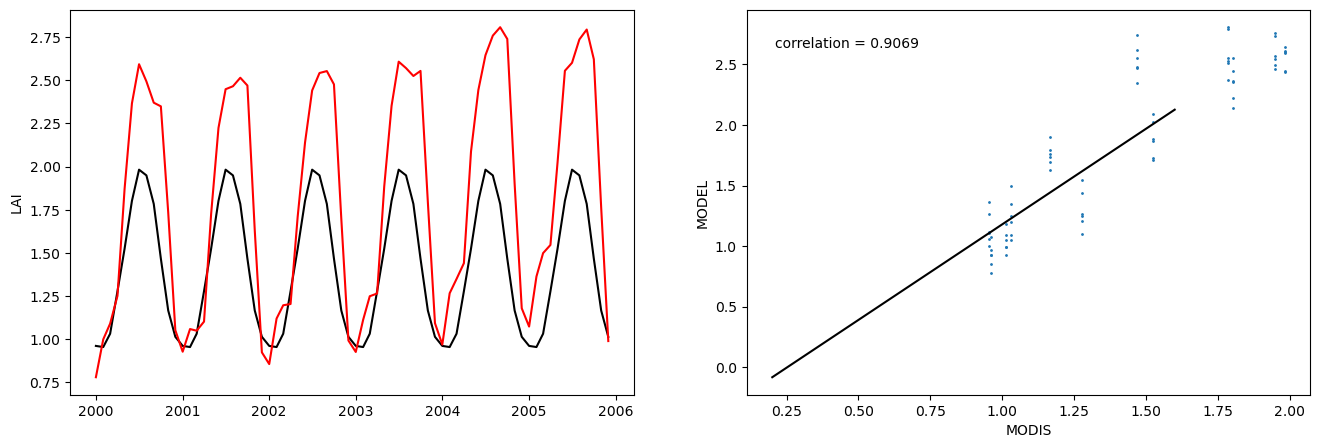

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (16, 5))

data = lai_obs.mean(axis = 2).mean(axis = 1)
data2 = lai_sim.mean(axis = 2).mean(axis = 1)

ax = axes.flat[0]
ax.plot(pd.date_range('2000-01-01', '2005-12-31', freq = '1MS'), data.values, '-k', label = 'MODIS')
ax.plot(pd.date_range('2000-01-01', '2005-12-31', freq = '1MS'), data2.values, '-r', label = 'Model')
ax.set_ylabel('LAI')

ax = axes.flat[1]
ax.plot(data.values, data2.values, 'o', markersize = 1)
ax.set_xlabel('MODIS')
ax.set_ylabel('MODEL')

res = linregress(data.values, data2.values)
ax.plot([0.2, 1.6], [0.2*res.slope+res.intercept, 1.6*res.slope+res.intercept], '-k')
rho, pval = pearsonr(data.values, data2.values)
ax.text(0.05, 0.9, f'correlation = {rho:.04f}', transform = ax.transAxes)

In [ ]:
modis.close()

# Compare against observed ET

In [ ]:
gleam = xr.open_dataset(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'ILAMB',
                                     'GLEAMv3.3a.nc'))

time_slice = slice('1990-01-01', '2009-12-31')  # Replace with your desired time range
bounding_box = {'lon': slice(-125.25, -66.5), 'lat': slice(23.25, 54.7)}
# mm/s => mm/day
et_obs = gleam['et'].sel(time=time_slice, lat=bounding_box['lat'], 
                         lon = bounding_box['lon']).resample(time='1MS').mean().load() * 86400
# mm/s => mm/day
et_sim = (hr['QVEGE'] + hr['QVEGT'] + hr['QSOIL']).resample(time='1MS').mean().load() * 86400

/ccsopen/home/ywo/.conda/envs/myCondaEnv/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'shrink'
  result = super().contourf(*args, **kwargs)


Text(0.05, 0.9, 'correlation = 0.7529')

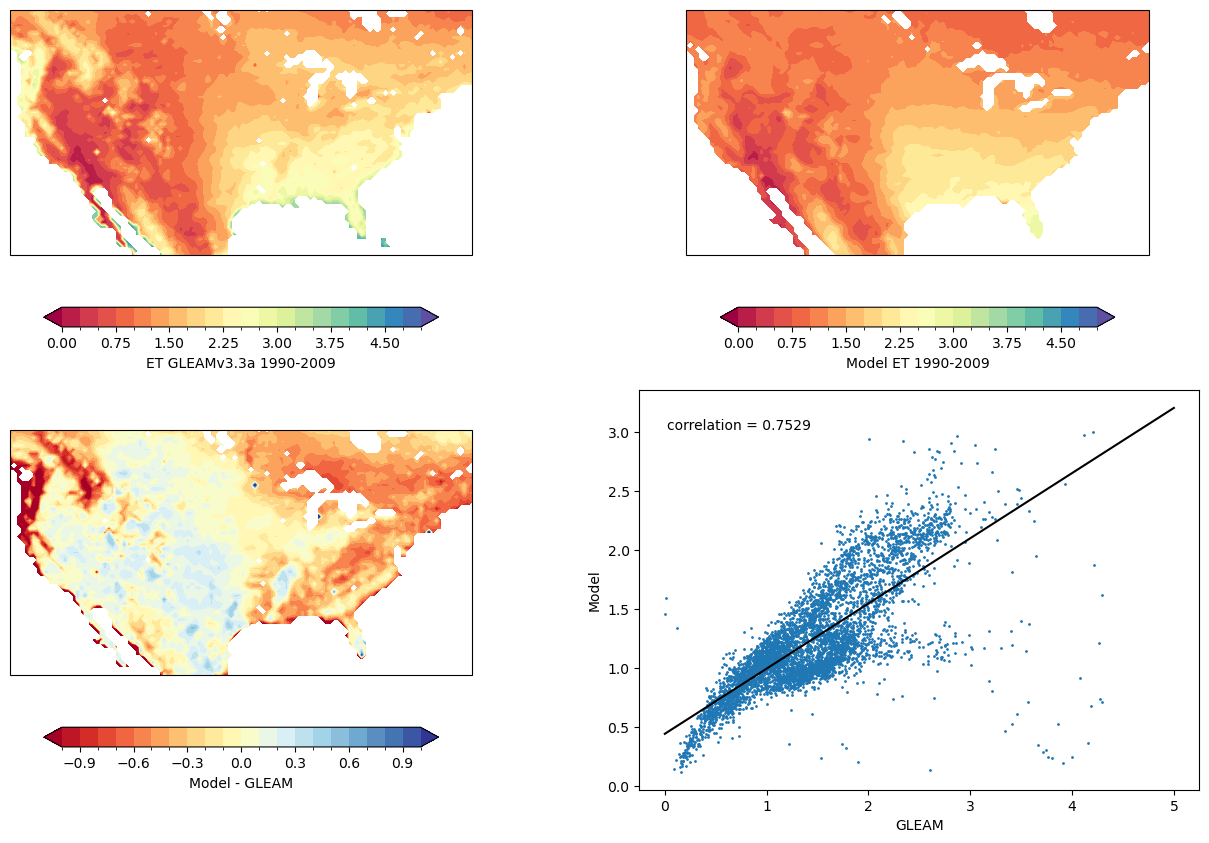

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (16, 10), subplot_kw = {'projection': ccrs.PlateCarree()})

levels = np.linspace(0, 5, 21)
norm = BoundaryNorm(levels, ncolors=256, extend='both')

ax = axes.flat[0]
data = et_obs.mean(axis = 0)
cf = ax.contourf(data['lon'], data['lat'], data, cmap = 'Spectral',
                 norm = norm, levels = levels, extend = 'both')
plt.colorbar(cf, ax = ax, label = 'ET GLEAMv3.3a 1990-2009', 
             orientation = 'horizontal', shrink = 0.7)

ax = axes.flat[1]
data2 = et_sim.mean(axis = 0)
cf = ax.contourf(data2['lon'], data2['lat'], data2,
                 cmap = 'Spectral', norm = norm, levels = levels, extend = 'both')
plt.colorbar(cf, ax = ax, label = 'Model ET 1990-2009', 
             orientation = 'horizontal', shrink = 0.7)

levels = np.linspace(-1, 1, 21)
norm = BoundaryNorm(levels, ncolors=256, extend='both')

ax = axes.flat[2]
cf = ax.contourf(data2['lon'], data2['lat'], data2 - data.values,
                 cmap = 'RdYlBu', norm = norm, levels = levels, extend = 'both', 
                 shrink = 0.7)
plt.colorbar(cf, ax = ax, label = 'Model - GLEAM', 
             orientation = 'horizontal', shrink = 0.7)

axes.flat[-1].axis('off')

cax = fig.add_axes([0.55, 0.1, 0.35, 0.4])

x = data.values.reshape(-1)
y = data2.values.reshape(-1)
filt = (x > 0) & (y > 0) # ELM runoff has tiny negative values!
x = x[filt]
y = y[filt]

cax.plot(x, y, 'o', markersize = 1)
cax.set_xlabel('GLEAM')
cax.set_ylabel('Model')

res = linregress(x, y)
cax.plot([0, 5], [0*res.slope+res.intercept, 5*res.slope+res.intercept], '-k')
rho, pval = pearsonr(x, y)
cax.text(0.05, 0.9, f'correlation = {rho:.04f}', transform = cax.transAxes)

Text(0.05, 0.9, 'correlation = 0.9837')

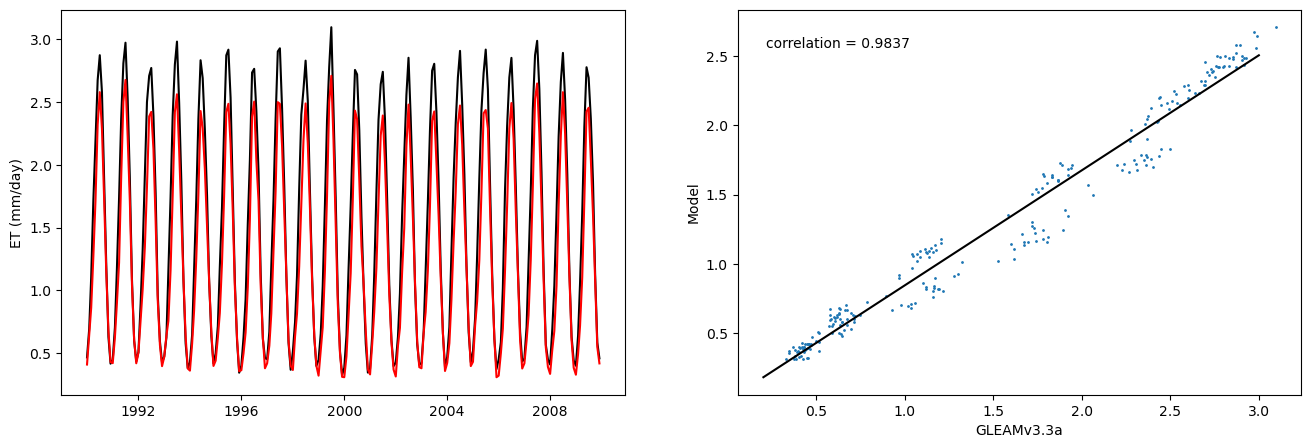

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (16, 5))

data = et_obs.mean(axis = 2).mean(axis = 1)
data2 = et_sim.mean(axis = 2).mean(axis = 1)

ax = axes.flat[0]
ax.plot(pd.date_range('1990-01-01', '2009-12-31', freq = '1MS'), data.values, '-k', 
        label = 'GLEAMv3.3a')
ax.plot(pd.date_range('1990-01-01', '2009-12-31', freq = '1MS'), data2.values, '-r', 
        label = 'Model')
ax.set_ylabel('ET (mm/day)')

ax = axes.flat[1]
ax.plot(data.values, data2.values, 'o', markersize = 1)
ax.set_xlabel('GLEAMv3.3a')
ax.set_ylabel('Model')

res = linregress(data.values, data2.values)
ax.plot([0.2, 3], [0.2*res.slope+res.intercept, 3*res.slope+res.intercept], '-k')
rho, pval = pearsonr(data.values, data2.values)
ax.text(0.05, 0.9, f'correlation = {rho:.04f}', transform = ax.transAxes)

In [ ]:
gleam.close()

# Compare against observed last day of snow

In [44]:
# ELM data
def last_day(array4D):
    def check(vec):
        has_snow = np.where(vec[:183] > 0)[0]
        if len(has_snow) > 0:
            return has_snow[-1]
        else:
            return np.nan
    return np.apply_along_axis(check, axis = 1, arr = array4D)

In [45]:
temp = hr['SNOWDP'].values.reshape(hr['SNOWDP'].shape[0]//365, 365, 
                                   hr['SNOWDP'].shape[1], hr['SNOWDP'].shape[2])
last_snow = last_day(temp)
last_snow = xr.DataArray(last_snow, dims = ['year','lat','lon'], 
                           coords = {'year': np.unique(hr['time'].to_index().year),
                                     'lat': hr['lat'], 'lon': hr['lon']})

In [46]:
# UA daily SWE product, probably the best quality available data
# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018GL079621
# https://nsidc.org/data/nsidc-0719/versions/1
# Temporal Coverage: 1 October 1981 to 30 September 2022
# Temporal Resolution: 1 day
# Spatial Resolution: 4 km x 4 km
filelist = [os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 'MODIS',
                         f'4km_SWE_Depth_WY{year}_v01.nc') for year in range(1990, 2011)]
swe_ua = xr.open_mfdataset(filelist)

new_lat = np.arange(23.25, 54.26, 0.5)
new_lon = np.arange(234.75, 293.26, 0.5) - 360
data_swe_ua = swe_ua['SWE'].interp(lat=new_lat, lon=new_lon, method = 'linear').load()

# remove leap days; Also the data follows hydrological year instead of physical year; re-work
noleap = data_swe_ua['time'].to_index()
noleap = (~((noleap.month == 2) & (noleap.day == 29))) & (noleap.year >= 1990) & (noleap.year <= 2009)
data_swe_ua = data_swe_ua[noleap, :, :]

temp = data_swe_ua.values.reshape(data_swe_ua.shape[0]//365, 365,
                                  data_swe_ua.shape[1],data_swe_ua.shape[2])
last_snow_ua = last_day(temp)
last_snow_ua = xr.DataArray(last_snow_ua, dims = ['year','lat','lon'], 
                            coords = {'year': np.unique(data_swe_ua['time'].to_index().year),
                                      'lat': data_swe_ua['lat'], 'lon': data_swe_ua['lon']})

swe_ua.close()

/ccsopen/home/ywo/.conda/envs/myCondaEnv/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'shrink'
  result = super().contourf(*args, **kwargs)


Text(0.05, 0.9, 'correlation = 0.8665')

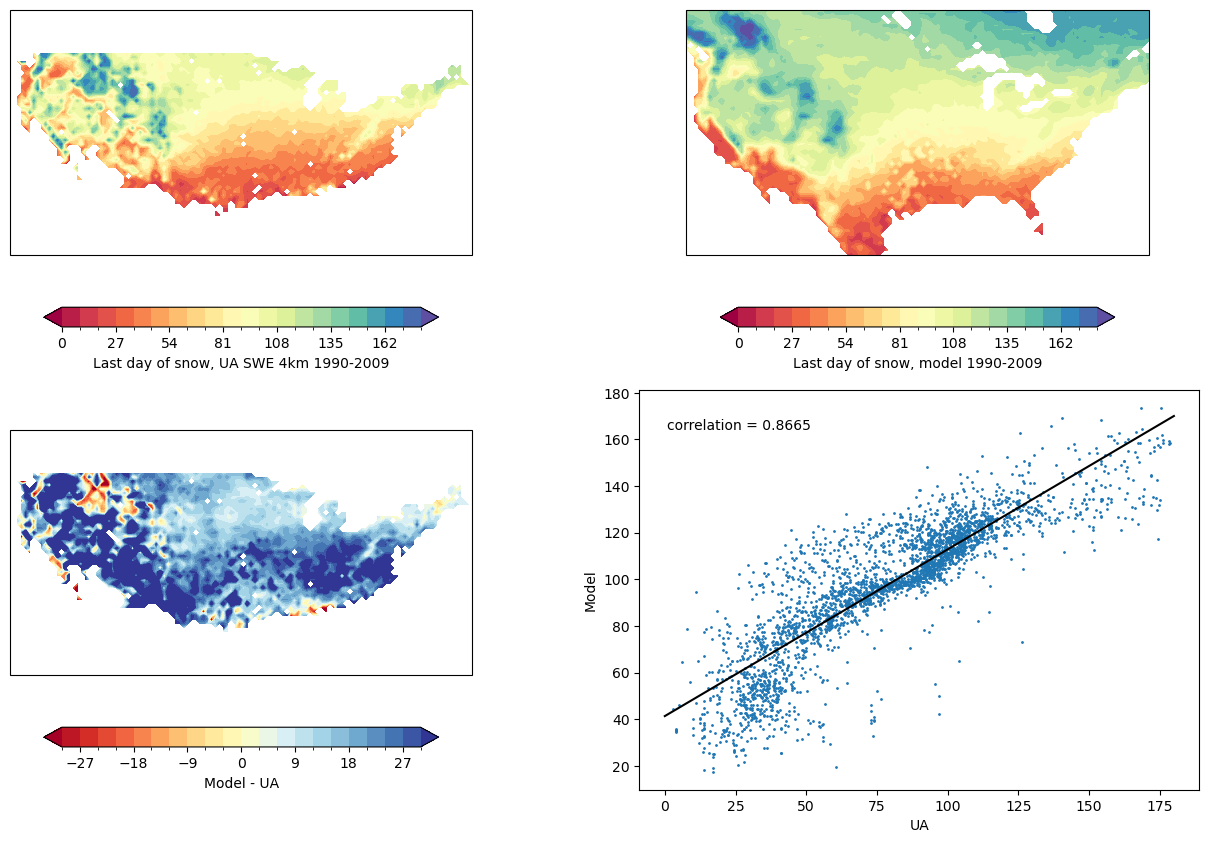

In [50]:
# The discrepancy in the lower latitudes is okay because there is probably little snow pack. 
fig, axes = plt.subplots(2, 2, figsize = (16, 10), subplot_kw = {'projection': ccrs.PlateCarree()})

levels = np.linspace(0, 180, 21)
norm = BoundaryNorm(levels, ncolors=256, extend='both')

ax = axes.flat[0]
data = last_snow_ua.mean(axis = 0)
cf = ax.contourf(data['lon'], data['lat'], data, cmap = 'Spectral',
                 norm = norm, levels = levels, extend = 'both')
plt.colorbar(cf, ax = ax, label = 'Last day of snow, UA SWE 4km 1990-2009', 
             orientation = 'horizontal', shrink = 0.7)

ax = axes.flat[1]
data2 = last_snow.mean(axis = 0)
cf = ax.contourf(data2['lon'], data2['lat'], data2,
                 cmap = 'Spectral', norm = norm, levels = levels, extend = 'both')
plt.colorbar(cf, ax = ax, label = 'Last day of snow, model 1990-2009', 
             orientation = 'horizontal', shrink = 0.7)

levels = np.linspace(-30, 30, 21)
norm = BoundaryNorm(levels, ncolors=256, extend='both')

ax = axes.flat[2]
cf = ax.contourf(data2['lon'], data2['lat'], data2 - data.values,
                 cmap = 'RdYlBu', norm = norm, levels = levels, extend = 'both', 
                 shrink = 0.7)
plt.colorbar(cf, ax = ax, label = 'Model - UA', 
             orientation = 'horizontal', shrink = 0.7)

axes.flat[-1].axis('off')

cax = fig.add_axes([0.55, 0.1, 0.35, 0.4])

x = data.values.reshape(-1)
y = data2.values.reshape(-1)
filt = (x > 0) & (y > 0) # ELM runoff has tiny negative values!
x = x[filt]
y = y[filt]

cax.plot(x, y, 'o', markersize = 1)
cax.set_xlabel('UA')
cax.set_ylabel('Model')

res = linregress(x, y)
cax.plot([0, 180], [0*res.slope+res.intercept, 180*res.slope+res.intercept], '-k')
rho, pval = pearsonr(x, y)
cax.text(0.05, 0.9, f'correlation = {rho:.04f}', transform = cax.transAxes)

In [ ]:
hr.close()

# Check radiation problem in the last years

Pre-2021 FSDS forcing data processing method is different from post-2021 FSDS forcing

Do not use year 2022

I've checked in with the CRU group and v2.3/v2.4 used a different cloud model that did not improve dswrf. I have updated dswrf files from Ian Harris at U of East Angelia that used the previous cloud model so solar radiation is in line with CRURJAv2.2 but with the updated 2021 year. I want to point out that if you did not get your files from CEDA, or by proxy through the WrPMIP file share on Globus, and instead have files from TRENDY "CRUJRAv2.3", then you are using different solar radiation. Ian mentioned that TRENDY doesn't use dswrf and instead has a different cloud model for direct/diffuse solar radiation

In [ ]:
flist = [os.path.join(os.environ['PROJDIR'], 'E3SM', 'output', 
                      'ERW_ctrl_hcru_hcru_ICB20TRCNPRDCTCBC', 'run', 
                      f'ERW_ctrl_hcru_hcru_ICB20TRCNPRDCTCBC.elm.h1.{year}-01-01-00000.nc') \
         for year in range(2019, 2023)]
hr = xr.open_mfdataset(flist)

varname = 'FSDS'

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (20, 15))
hr[varname].sel(time=slice('2019-01-01','2019-12-31')).mean(axis = 0).plot(ax = axes.flat[0])
hr[varname].sel(time=slice('2020-01-01','2020-12-31')).mean(axis = 0).plot(ax = axes.flat[1])
hr[varname].sel(time=slice('2021-01-01','2021-12-31')).mean(axis = 0).plot(ax = axes.flat[2])
hr[varname].sel(time=slice('2022-01-01','2022-12-31')).mean(axis = 0).plot(ax = axes.flat[3])

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (20, 15))
hr[varname].sel(time=slice('2019-01-01','2019-12-31')).max(axis = 0).plot(ax = axes.flat[0])
hr[varname].sel(time=slice('2020-01-01','2020-12-31')).max(axis = 0).plot(ax = axes.flat[1])
hr[varname].sel(time=slice('2021-01-01','2021-12-31')).max(axis = 0).plot(ax = axes.flat[2])
hr[varname].sel(time=slice('2022-01-01','2022-12-31')).max(axis = 0).plot(ax = axes.flat[3])

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (20, 15))
hr[varname].sel(time=slice('2019-01-01','2019-12-31')).min(axis = 0).plot(ax = axes.flat[0])
hr[varname].sel(time=slice('2020-01-01','2020-12-31')).min(axis = 0).plot(ax = axes.flat[1])
hr[varname].sel(time=slice('2021-01-01','2021-12-31')).min(axis = 0).plot(ax = axes.flat[2])
hr[varname].sel(time=slice('2022-01-01','2022-12-31')).min(axis = 0).plot(ax = axes.flat[3])